# Отбор важных признаков

### Ира Пантелеева, Женя Глазунов

### План:

**Исследование**

1. Типы вопросов
2. Tf-Idf на частеречной разметке

**Отбор признаков**

1. Отбор признаков с помощью feature importance с помощью реализации в sklearn
2. Отбор перемешиванием
3. Отбор с помощью выкидывания признаков

In [2]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

import pickle
import scipy.sparse

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

pd.set_option('max_colwidth', 800)

In [2]:
from tqdm import tqdm_notebook as tqdm

In [3]:
df = pd.read_csv('/home/dkbrz/all/train.csv')

In [4]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


In [8]:
df.shape

(1306122, 3)

## Baseline

In [12]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=20, max_df=0.5, max_features=100)

In [13]:
data = vectorizer.fit_transform(df.question_text)

In [15]:
LR = LogisticRegression(solver='lbfgs', max_iter=1000)

In [16]:
cross_val_score(LR, data, df.target, cv=5, scoring='roc_auc').mean()

0.841395618731003

**сохраняем векторайзер**

In [14]:
pickle.dump(vectorizer, open('vect.pkl','wb'))

**... и данные**

In [17]:
scipy.sparse.save_npz('data100.npz', data)

In [11]:
scipy.sparse.save_npz('data.npz', data)

In [5]:
data = scipy.sparse.load_npz('data100.npz')

In [6]:
vectorizer = pickle.load(open('vect.pkl','rb'))

## Исследование вопросов

In [7]:
def norm_q(text):
    t2 = [i if i.isalpha() else ' ' for i in text.lower()]
    t2 = ''.join(t2).strip()
    t2 = t2.split(' ')
    return lemmatizer.lemmatize(t2[0])

In [59]:
'a'.isalpha()

True

In [8]:
df['question'] = df.question_text.apply(norm_q)

In [61]:
QM = df['question'].value_counts()

In [62]:
QM

what              408769
how               247094
why               134935
is                 95266
can                48639
which              45234
do                 35540
if                 27709
i                  26229
are                25850
who                21524
doe                20211
where              18110
should             13526
when               13493
will               11838
in                  8725
would               8065
have                6718
a                   6607
did                 6565
my                  5996
ha                  5361
could               3770
wa                  3636
the                 2357
for                 1557
after               1447
at                  1207
with                1186
                   ...  
libertarianism         1
mo                     1
proprietor             1
palakaya               1
whict                  1
logistical             1
menstruation           1
grey                   1
ethiopan               1


In [63]:
QM_over100 = QM[QM>1000]

In [64]:
%matplotlib inline

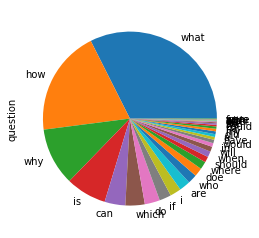

In [65]:
QM_over100.plot.pie()

## POS-tagging

In [ ]:
import nltk
from nltk import word_tokenize
t_l_p_r = []
for x in tqdm(df['question_text']):
    text = word_tokenize(x)
    POS = ' '.join([y[1] for y in nltk.pos_tag(text)])
    t_l_p_r.append(POS)
df['POS'] = t_l_p_r
df.to_csv('df2.csv', index_col = False)

## Отбор признаков

### Часть 1. skearn

In [7]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

In [8]:
# Build a forest and compute the feature importances
forest = RandomForestClassifier(n_estimators=8,
                              random_state=23,
                             verbose=3, n_jobs=-1)
forest.fit(data, df.target)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 8
building tree 2 of 8
building tree 3 of 8
building tree 4 of 8building tree 5 of 8
building tree 6 of 8
building tree 7 of 8

building tree 8 of 8


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  5.1min remaining: 15.3min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:  5.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  5.2min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=8, n_jobs=-1,
            oob_score=False, random_state=23, verbose=3, warm_start=False)

In [9]:
vocab = vectorizer.vocabulary_
ind2words = {vocab[i]:i for i in vocab}

ind2words

labels = [ind2words[i] for i in range(len(vocab))]

In [12]:
importances = forest.feature_importances_

In [13]:
importances

array([0.00935719, 0.00362055, 0.008977  , 0.00350771, 0.00772324,
       0.02838296, 0.00513749, 0.02827336, 0.00150636, 0.00315508,
       0.01202145, 0.00585464, 0.0110874 , 0.00135173, 0.00170869,
       0.00628677, 0.00973578, 0.01215967, 0.00788945, 0.02202253,
       0.00431806, 0.00975562, 0.0161747 , 0.00941555, 0.00667418,
       0.0037933 , 0.00656913, 0.01492244, 0.00666302, 0.01606008,
       0.00336033, 0.00477051, 0.00055997, 0.0135091 , 0.02339825,
       0.00729472, 0.00731061, 0.02572451, 0.00725338, 0.00476087,
       0.00028773, 0.00217565, 0.01628405, 0.00361808, 0.00226538,
       0.01144986, 0.00471806, 0.00655996, 0.00598634, 0.00748792,
       0.00695392, 0.003645  , 0.01132188, 0.01110188, 0.02522632,
       0.00652145, 0.01264939, 0.00422473, 0.01255709, 0.00600067,
       0.00485248, 0.02231642, 0.00789475, 0.01807845, 0.00558329,
       0.00285416, 0.00704096, 0.02167913, 0.0381359 , 0.00110612,
       0.01746905, 0.00748438, 0.02158038, 0.00719902, 0.00752

In [14]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(data.shape[1]):
    print("%d. %s (%f)" % (f + 1, labels[indices[f]], importances[indices[f]]))

Feature ranking:
1. why (0.064377)
2. the (0.038136)
3. to (0.032672)
4. and (0.028383)
5. are (0.028273)
6. what (0.026970)
7. is (0.025725)
8. of (0.025226)
9. in (0.023398)
10. people (0.022316)
11. do (0.022023)
12. that (0.021679)
13. they (0.021580)
14. why do (0.020890)
15. so (0.018078)
16. their (0.017469)
17. it (0.016284)
18. for (0.016175)
19. how (0.016060)
20. with (0.015222)
21. have (0.014922)
22. if (0.013509)
23. you (0.013131)
24. on (0.012649)
25. or (0.012557)
26. can (0.012160)
27. as (0.012021)
28. like (0.011450)
29. when (0.011440)
30. my (0.011322)
31. not (0.011102)
32. be (0.011087)
33. who (0.010412)
34. does (0.009756)
35. by (0.009736)
36. from (0.009416)
37. about (0.009357)
38. all (0.008977)
39. we (0.008583)
40. will (0.008191)
41. should (0.007895)
42. did (0.007889)
43. would (0.007849)
44. an (0.007723)
45. this (0.007521)
46. more (0.007488)
47. there (0.007484)
48. was (0.007435)
49. india (0.007311)
50. in the (0.007295)
51. is it (0.007253)
52.

In [15]:
indices

array([92, 68, 76,  5,  7, 82, 37, 54, 34, 61, 19, 67, 72, 93, 63, 70, 42,
       22, 29, 96, 27, 33, 98, 56, 58, 17, 10, 45, 88, 52, 53, 12, 91, 21,
       16, 23,  0,  2, 81, 95, 62, 18, 97,  4, 74, 49, 71, 79, 36, 35, 38,
       73, 66, 50, 24, 28, 26, 47, 55, 15, 59, 48, 11, 94, 64,  6, 99, 60,
       31, 39, 46, 77, 90, 20, 57, 25, 51,  1, 43,  3, 30,  9, 86, 65, 75,
       78, 83, 80, 89, 44, 41, 14, 87,  8, 13, 85, 69, 32, 84, 40])

In [16]:
lbls = [labels[f] for f in indices]

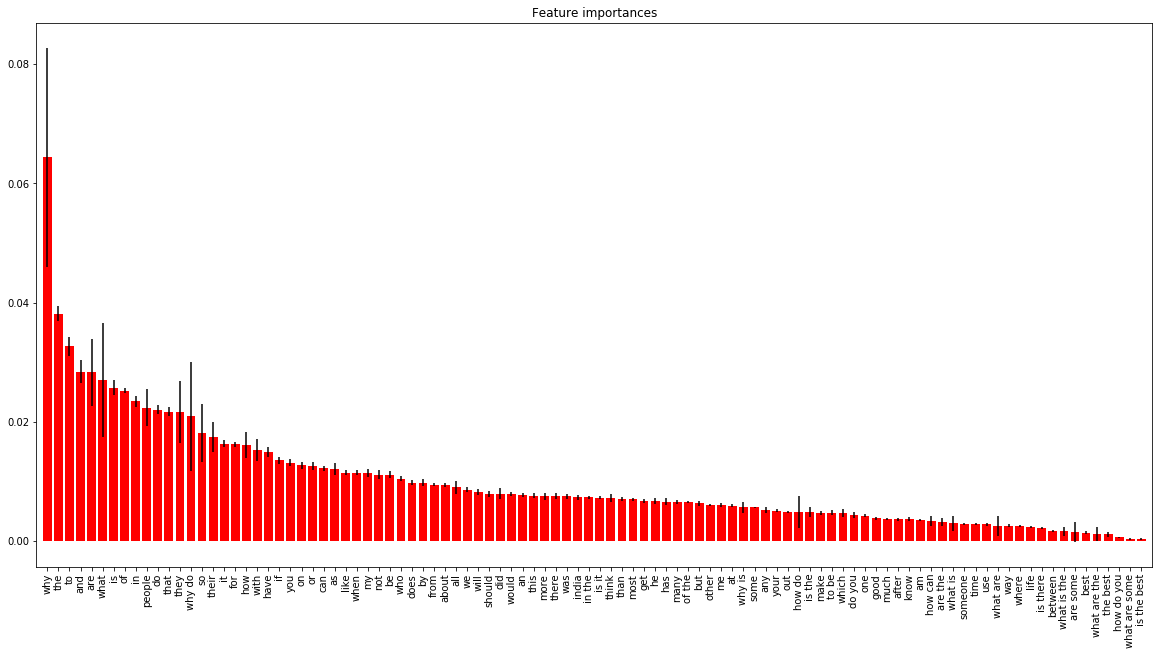

In [17]:
# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(data.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(data.shape[1]), lbls, rotation='vertical')
plt.xlim([-1, data.shape[1]])
plt.show()

In [18]:
from sklearn.metrics import roc_auc_score

In [ ]:
rf = RandomForestClassifier(n_estimators=8, verbose=3, random_state=23, n_jobs=-1)
rf.fit(data, df.target) # rf must be pre-trained

In [9]:
def permutation_importances(rf, X_train, y_train, metric):
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in tqdm(X_train.columns):
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

In [10]:
from sklearn.ensemble.forest import _generate_unsampled_indices


In [11]:
def oob_classifier_accuracy(rf, X_train, y_train):
    """
    Compute out-of-bag (OOB) accuracy for a scikit-learn random forest
    classifier. We learned the guts of scikit's RF from the BSD licensed
    code:
    https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/forest.py#L425
    """
    X = X_train.values
    y = y_train.values

    n_samples = len(X)
    n_classes = len(np.unique(y))
    predictions = np.zeros((n_samples, n_classes))
    for tree in rf.estimators_:
        unsampled_indices = _generate_unsampled_indices(tree.random_state, n_samples)
        tree_preds = tree.predict_proba(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds

    predicted_class_indexes = np.argmax(predictions, axis=1)
    predicted_classes = [rf.classes_[i] for i in predicted_class_indexes]

    oob_score = np.mean(y == predicted_classes)
    return oob_score

In [31]:
A = pd.DataFrame(data.todense())

imp = permutation_importances(rf, A, df.target,
                              oob_classifier_accuracy)

lbls = [labels[f] for f in imp.index]

imp.head()

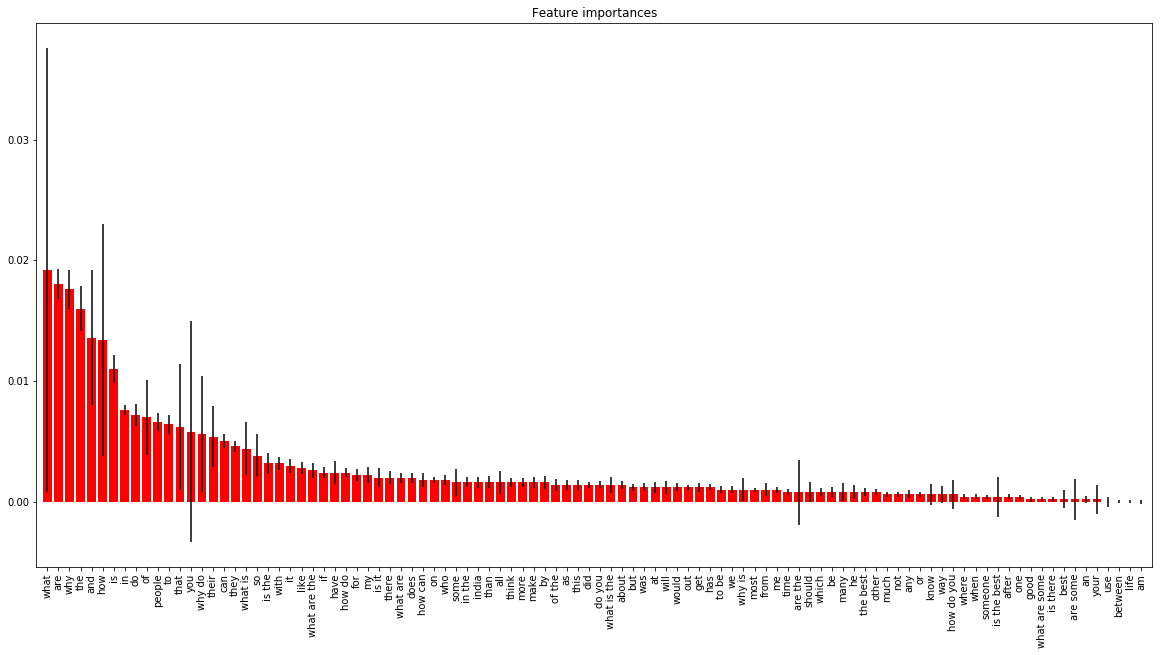

In [45]:
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(data.shape[1]), imp.Importance,
       color="r", yerr=std[indices], align="center")
plt.xticks(range(data.shape[1]), lbls, rotation='vertical')
plt.xlim([-1, data.shape[1]])
plt.show()

## Объединение признаков 

In [10]:
from scipy import sparse

In [11]:
pos_vec = pickle.load(open('/home/dkbrz/all/vect_pos.pkl', 'rb'))
pos_data = sparse.load_npz('/home/dkbrz/all/datapos.npz')

/home/dkbrz/.local/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/dkbrz/.local/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [68]:
LR = LogisticRegression(solver='lbfgs', max_iter=1000)
cross_val_score(LR, pos_data, df.target, cv=5, scoring='roc_auc').mean()

0.8009814194746344

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
quest_vec = CountVectorizer(max_features=100)
questions = quest_vec.fit_transform(df['question'])

In [69]:
LR = LogisticRegression(solver='lbfgs', max_iter=1000)
cross_val_score(LR, questions, df.target, cv=5, scoring='roc_auc').mean()

0.7863153079125172

**объединяем**

Проблемы с паматью

In [14]:
tfidf = pd.DataFrame(data.todense())
tfidf.columns = labels

In [15]:
pos = pd.DataFrame(pos_data.todense())

In [16]:
vocab = pos_vec.vocabulary_
ind2words = {vocab[i]:i for i in vocab}
ind2words = [ind2words[i] for i in range(len(vocab))]

In [17]:
pos.columns = ind2words

In [18]:
del pos_data, data, vectorizer, pos_vec

In [19]:
quest = pd.DataFrame(questions.todense())
vocab = quest_vec.vocabulary_
ind2words = {vocab[i]:i for i in vocab}
ind2words = [ind2words[i] for i in range(len(vocab))]
quest.columns = ind2words

In [22]:
tfidf.to_csv('tfidf.csv', sep='\t', index=False)

In [23]:
pos.to_csv('pos.csv', sep='\t', index=False)
quest.to_csv('quest.csv', sep='\t', index=False)

In [1]:
import pandas as pd
import numpy as np

In [2]:
#tfidf = pd.read_csv('tfidf.csv', sep='\t')
pos = pd.read_csv('pos.csv', sep='\t')
quest = pd.read_csv('quest.csv', sep='\t')

In [3]:
DF = pd.concat([pos, quest])

/home/dkbrz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [ ]:
rf = RandomForestClassifier(n_estimators=8, verbose=2, random_state=23, n_jobs=-1)
rf.fit(DF, target) # rf must be pre-trained
imp = permutation_importances(rf, DF, target,
                              roc_auc_score)

In [ ]:
imp = permutation_importances(rf, A, df.target,
                              oob_classifier_accuracy)

lbls = [labels[f] for f in imp.index]

imp.head()

In [ ]:
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(data.shape[1]):
    print("%d. %s (%f)" % (f + 1, labels[indices[f]], importances[indices[f]]))

In [ ]:
# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(data.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(data.shape[1]), lbls, rotation='vertical')
plt.xlim([-1, data.shape[1]])
plt.show()

### Ну, посмотрим хоть на части речи

In [4]:
pos_vec = pickle.load(open('/home/dkbrz/all/vect_pos.pkl', 'rb'))
pos_data = scipy.sparse.load_npz('/home/dkbrz/all/datapos.npz')

In [5]:
target = pd.read_csv('/home/dkbrz/all/train.csv')['target']

In [8]:
rf = RandomForestClassifier(n_estimators=8, verbose=3, random_state=23, n_jobs=-1)
rf.fit(pos_data, target) # rf must be pre-trained

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 8
building tree 2 of 8
building tree 3 of 8building tree 4 of 8
building tree 5 of 8

building tree 6 of 8
building tree 7 of 8
building tree 8 of 8


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  4.5min remaining: 13.4min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:  4.6min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  4.6min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=8, n_jobs=-1,
            oob_score=False, random_state=23, verbose=3, warm_start=False)

In [13]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
A = pd.DataFrame(pos_data.todense())

imp = permutation_importances(rf, A, target,
                              oob_classifier_accuracy)

In [16]:
vocab = pos_vec.vocabulary_
ind2words = {vocab[i]:i for i in vocab}
ind2words = [ind2words[i] for i in range(len(vocab))]

In [19]:
len(ind2words)

50

In [21]:
A.columns = ind2words

In [23]:
imp

array([0.00109867, 0.00025419, 0.00158791, 0.00131764, 0.00161088,
       0.00092028, 0.0008843 , 0.00111092, 0.00085367, 0.00038434,
       0.00035755, 0.00192478, 0.00226472, 0.0013475 , 0.00233516,
       0.0029913 , 0.00278305, 0.00226166, 0.00024883, 0.00250819,
       0.00091416, 0.00056733, 0.00035295, 0.0058823 , 0.00016691,
       0.00109791, 0.00381817, 0.00119973, 0.00559749, 0.00047775,
       0.00386717, 0.00104891, 0.00150981, 0.00176477, 0.00184592,
       0.00043411, 0.00032616, 0.00067758, 0.00062781, 0.00075644,
       0.00041344, 0.00740053, 0.00167595, 0.00136817, 0.00294995,
       0.00137813, 0.00443067, 0.00153814, 0.00249517, 0.00364591])

In [24]:
df = pd.DataFrame({'ind':ind2words, 'imp':imp})

In [35]:
df.sort_values(by='imp', ascending=False)

,ind,imp
41,vbp,0.007401
23,nnp,0.005882
28,prp,0.005597
46,wp,0.004431
30,prp vb,0.003867
26,nns,0.003818
49,wrb,0.003646
15,md,0.002991
44,vbz,0.002950
16,md prp,0.002783


ValueError: shape mismatch: objects cannot be broadcast to a single shape

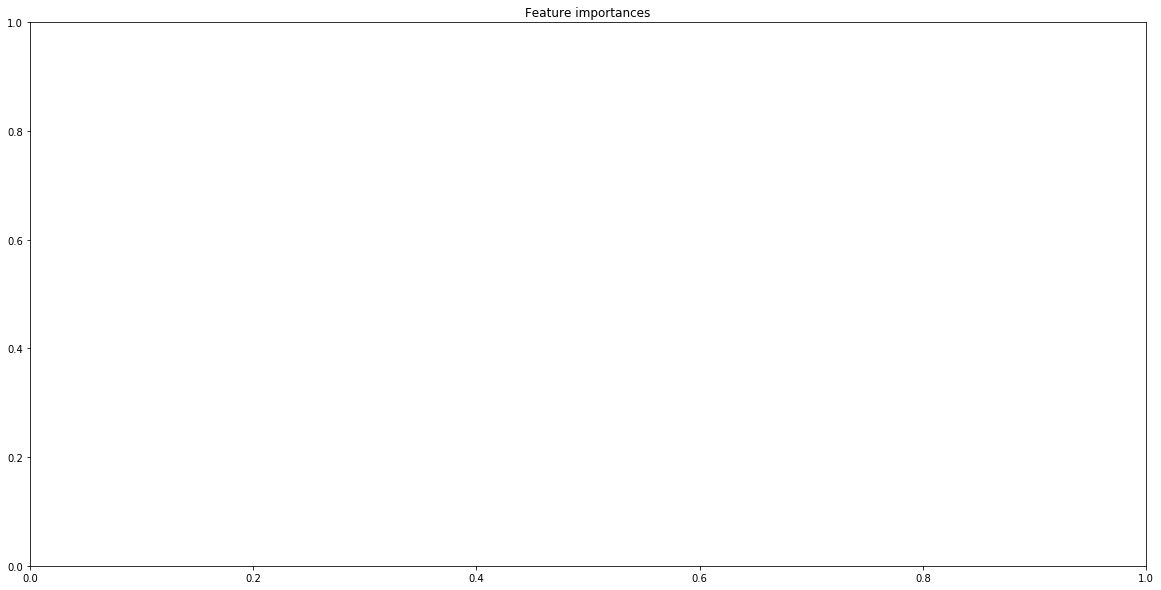

In [29]:
#lbls = [ind2words[f] for f in A.index]
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(df.shape[1]), df.imp,
       color="r", align="center")
plt.xticks(range(data.shape[1]), df.ind, rotation='vertical')
plt.xlim([-1, pos_data.shape[1]])
plt.show()

Кажется, что отбор с перемешиванием работает лучше, результаты более интерпретируемые, нграммы могут попадать в топ. Но нужно делать какую-то реализацию с разреженными данными, потому что на них работает плохо.

**И вообще, нужно обучаться на большом количестве признаков, а это долго и плохо по памяти, надо это учесть**